In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from experiments.models import model_purchase100
import experiments.data_utils

/home/enoch/g/diplomski/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.compat.v1.disable_eager_execution()

(x_train, y_train), (x_test, y_test), (x_shadow, y_shadow) = experiments.data_utils.load_purchase100(shadow_size=0.75)
model = model_purchase100()
model.summary()
model_weights_path="./trained_models/purchase100-weights-best.hdf5"
try:
    model.load_weights(model_weights_path)
    print("Loaded model weights successfully from file ", model_weights_path)
except:
    print("No trained model found, please check path")

./datasets/dataset_purchase
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 1024)              615424    
                                                                 
 layer2 (Dense)              (None, 512)               524800    
                                                                 
 layer3 (Dense)              (None, 256)               131328    
                                                                 
 layer4 (Dense)              (None, 128)               32896     
                                                                 
 layer5 (Dense)              (None, 100)               12900     
                                                                 
Total params: 1,317,348
Trainable params: 1,317,348
Non-trainable params: 0
_________________________________________________________________


2022-05-06 12:54:45.657646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 12:54:45.693378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 12:54:45.693599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 12:54:45.694308: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Loaded model weights successfully from file  ./trained_models/purchase100-weights-best.hdf5


2022-05-06 12:54:46.141187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 12:54:46.141450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 12:54:46.141638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 12:54:46.141795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4823 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:0a:00.0, compute capability: 6.1


In [28]:
import cma
import optuna
import numpy as np
import pandas as pd
from cmaes import CMA

from experiments.data_utils import random_record_purchase100
from typing import Callable, Optional

def generate_zeroes(n_features):
    return np.zeros(shape=(n_features,))

def generate_class_label(n_labels, target_label):
    new_y = np.zeros(shape=(n_labels,))
    new_y[target_label] = 1
    return new_y

class CMAEvaluator():
    def __init__(self, model, y_target, target_class):
        self._model = model
        self._y_target = y_target
        self._target_class = target_class
    
    def preproc_x_float(self, x):
        np.clip(x, a_min=0, a_max=1, out=x)
        x = np.around(x)
        return x
    
    def evaluate(self, x):
        x = self.preproc_x_float(x)
        prediction = self._model.predict(x.reshape(1, -1))[0]
        class_confidence = prediction[self._target_class]
        dist = np.linalg.norm(self._y_target - prediction)
        #dist = abs(1 - class_confidence)
        return dist
    
def generate_class_representative_cmaes(
    target_classifier: "CLASSIFIER_TYPE",
    target_class: int,
    min_confidence: float,
    max_features_randomized: Optional[int],
    min_num_samples: Optional[int],
    max_iterations: int = 50,
    max_rejections: int = 3,
    min_features_randomized: int = 1,
    random_record_fn: Callable[[], np.ndarray] = None,
    randomize_features_fn: Callable[[np.ndarray, int], np.ndarray] = None,
) -> np.ndarray:
    import matplotlib.pyplot as plt
    
    y_target = generate_class_label(100, target_class)
    
    evaluator = CMAEvaluator(target_classifier, y_target, target_class)
    fun = evaluator.evaluate

    candidates = set()
    
    def objective(trial):
        x_zeros = 600 * [0]
        for i in range(600):
            x_zeros[i] = trial.suggest_int("x" + str(i), 0, 1)
        candidates.add(tuple(x_zeros))
        x_zeros = np.asarray(x_zeros)
        return evaluator.evaluate(x_zeros)

    def logging_callback(study, frozen_trial):
        previous_best_value = study.user_attrs.get("previous_best_value", None)
        if previous_best_value != study.best_value:
            study.set_user_attr("previous_best_value", study.best_value)
            print(
                "Trial {} finished with best value: {} and parameters: {}. ".format(
                frozen_trial.number,
                frozen_trial.value,
                frozen_trial.params,
                )
            )

        
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    sampler = optuna.samplers.CmaEsSampler(n_startup_trials=100, restart_strategy="ipop")
    study = optuna.create_study(
        direction="minimize",
        sampler=sampler,
    )
    study.optimize(objective, n_trials=max_iterations, callbacks=[logging_callback])
    
    print(study.best_value)
    print("best", study.best_params)
    
    candidates = np.array(list(candidates))
    
    feature_count_and_plot_histogram(candidates, nbins=600, normalize=True)
    
    preprocessed = []
    for i in range(len(candidates)):
        preprocessed.append(evaluator.preproc_x_float(candidates[i]))
        
    preprocessed = np.asarray(preprocessed)
    # Filter multiples of same solutions
    preprocessed = np.unique(preprocessed, axis=0)
    print("Number of unique candidates after preprocessing ", preprocessed.shape)
    print("Preprocessed candidates:\n", preprocessed)
    
    predictions = target_classifier.predict(preprocessed)
    print("Prediction vectors:\n", predictions)
    
    predicted_labels = np.argmax(predictions, axis=1)
    print("Predicted labels:\n", predicted_labels)
    print(predictions[np.arange(len(predictions)), predicted_labels])
    
    
    # izgleda dobro ali mislim da bi bilo ok dodati jos nekakve perturbacije za povecanje uzorka
    # a i htio bih provjeriti jesu li svi uzorci zaista jedinstveni
    # ako zadovoljim oba uvjeta, mislim da ce algoritam biti spreman za pravu generaciju
    if len(preprocessed) != 0:
        return preprocessed, np.around(predictions)
    else:
        raise RuntimeError("Failed to synthesize data record")

def calc_2d_intersection(A, B, assume_unique=False, return_indices=False):

    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [A.dtype]}

    C = np.intersect1d(A.view(dtype), B.view(dtype), assume_unique=assume_unique, return_indices=return_indices)

    # This last bit is optional if you're okay with "C" being a structured array...
    C = C.view(A.dtype).reshape(-1, ncols)
    return C

def calc_2d_intersection_sets(A, B, assume_unique=False, return_indices=False):
    aset = set([tuple(x) for x in A])
    bset = set([tuple(x) for x in B])
    return np.array([x for x in aset & bset])

def feature_count_and_plot_histogram(xs, nbins: int, normalize=True):
    xs = np.count_nonzero(xs, axis=1)
    print(xs.shape)
    s = pd.Series(xs)
    print("\nFEATURE   COUNT\n",s.value_counts(normalize))
    s.plot.hist(bins=nbins, density=normalize, range=(0, nbins))

In [ ]:
import time

start = time.time()

n_features = x_train[0].shape[0]
n_labels = y_train[0].shape[0]
target_class = 1
min_confidence = 0.4
max_features_randomized = n_features * 0.05
max_iterations = 500
max_rejections = 10
min_features_randomized = 1
sample_size = 100

#print(generate_class_label(n_labels, target_class))
#print(zeros)

x_cl, y_cl = generate_class_representative_cmaes(
    model,
    target_class,
    min_confidence,
    max_features_randomized,
    min_num_samples = sample_size,
    max_iterations = max_iterations,
    max_rejections = max_rejections,
    min_features_randomized = min_features_randomized,
)

end = time.time()
print("CMA-ES duration: ", end - start)

x_cl = x_cl.astype(np.int64, casting="unsafe")
print("Generated {} vectors", x_cl.shape)

x_all = np.concatenate((x_train, x_test, x_shadow), axis=0)
y_all = np.concatenate((y_train, y_test, y_shadow), axis=0)

indices = np.where(np.argmax(y_all, axis=1) == target_class)
intersection = calc_2d_intersection_sets(x_all[indices], x_cl, assume_unique=False, return_indices=False)
print("All feature vector intersect ", intersection)

indices = np.where(np.argmax(y_train, axis=1) == target_class)
#print(x_train[indices][0])
#print(x_train.dtype)
#print(x_cl[1])
#print(x_cl.dtype)
intersection = calc_2d_intersection_sets(x_train[indices], x_cl, assume_unique=False, return_indices=False)
print("Training feature vector intersect", intersection)

#feature_count_and_plot_histogram(x_cl, nbins=600, normalize=True)

/home/enoch/g/diplomski/env/lib/python3.8/site-packages/optuna/samplers/_cmaes.py:221: ExperimentalWarning: `restart_strategy` option is an experimental feature. The interface can change in the future.
  warnings.warn(


Trial 0 finished with best value: 1.396265983879842 and parameters: {'x0': 1, 'x1': 0, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 1, 'x6': 1, 'x7': 1, 'x8': 1, 'x9': 0, 'x10': 1, 'x11': 0, 'x12': 0, 'x13': 0, 'x14': 0, 'x15': 0, 'x16': 0, 'x17': 0, 'x18': 0, 'x19': 1, 'x20': 0, 'x21': 1, 'x22': 1, 'x23': 0, 'x24': 1, 'x25': 0, 'x26': 1, 'x27': 1, 'x28': 1, 'x29': 1, 'x30': 0, 'x31': 0, 'x32': 0, 'x33': 1, 'x34': 0, 'x35': 0, 'x36': 0, 'x37': 1, 'x38': 0, 'x39': 0, 'x40': 1, 'x41': 1, 'x42': 0, 'x43': 0, 'x44': 0, 'x45': 0, 'x46': 0, 'x47': 0, 'x48': 0, 'x49': 1, 'x50': 1, 'x51': 0, 'x52': 0, 'x53': 0, 'x54': 0, 'x55': 0, 'x56': 1, 'x57': 0, 'x58': 1, 'x59': 1, 'x60': 1, 'x61': 0, 'x62': 0, 'x63': 1, 'x64': 0, 'x65': 0, 'x66': 1, 'x67': 0, 'x68': 1, 'x69': 1, 'x70': 0, 'x71': 0, 'x72': 0, 'x73': 1, 'x74': 1, 'x75': 1, 'x76': 0, 'x77': 1, 'x78': 1, 'x79': 1, 'x80': 1, 'x81': 1, 'x82': 0, 'x83': 1, 'x84': 0, 'x85': 1, 'x86': 0, 'x87': 0, 'x88': 0, 'x89': 1, 'x90': 1, 'x91': 0, 'x92': 0, 'x93': 1, '

[W 2022-05-06 14:47:09,953] The parameter 'x60' in trial#146 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2022-05-06 14:47:09,969] The parameter 'x398' in trial#146 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2022-05-06 14:47:47,195] The parameter 'x93' in trial#147 is sampled independently by using `RandomSampler` instead of `CmaEsSampl

In [19]:
feature_count_and_plot_histogram(x_cl, nbins=600, normalize=True)
indices = np.where(np.argmax(y_all, axis=1) == target_class)
feature_count_and_plot_histogram(x_all[indices], nbins=600, normalize=True)

(10000,)

FEATURE   COUNT
 298    0.0349
300    0.0339
301    0.0329
296    0.0318
295    0.0317
        ...  
257    0.0001
258    0.0001
259    0.0001
247    0.0001
263    0.0001
Length: 85, dtype: float64
(864,)

FEATURE   COUNT
 92     0.046296
96     0.038194
90     0.038194
91     0.035880
95     0.035880
         ...   
173    0.001157
177    0.001157
180    0.001157
183    0.001157
77     0.001157
Length: 88, dtype: float64


### Interpretacija rezultata
Očito, generirani vektori značajki koji maksimiziraju vjerojatnost klasifikacije za svoju klasu jako odstupaju od pravih vektora na kojima se model trenira. Mislim da se radi o sljedećem:
u originalnom radu, autori su predložili sintezu takvu da koristimo hill-climbing algoritam i perturbiramo vektor, čuvamo najbolji sample i želimo ga pomicati u smjeru u kojem maksimizira vjerojatnost klasifikacije za klasu za koju želimo generirati sample. Mislim da iz ovoga ispada da to nije dovoljno dobra heuristika, jer smo za primjere koji su klasificirani s vrlo visokom vjerojatnosti dobili značajno drugačije vektore, i čini mi se da bi trebalo u funkciju cilja dodati dodatne uvjete koji rade... što točno?

Explained variation per principal component: [0.00242039 0.00241853]


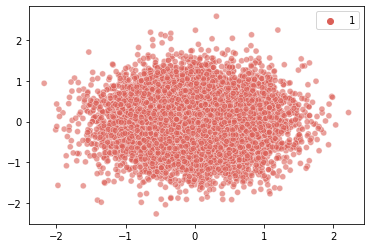

Explained variation per principal component: [0.02448444 0.01885211]


In [20]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

x_class = x_all[indices]

def plot_pca(data, n_components=2):
    pca = PCA(n_components)
    pca_res = pca.fit_transform(data)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))    

    plt.figure()
    sns.scatterplot(
        x=pca_res[:,0], y=pca_res[:,1],
        hue=1,
        palette=sns.color_palette("hls", 1),
        data=pca_res,
        legend="full",
        alpha=0.6
    )
    plt.show()


plot_pca(x_cl)
plot_pca(x_class)

In [21]:
def plot_tsne(data, n_components=2, verbose=1, perplexity=40, n_iter=1000):
    time_start = time.time()
    tsne = TSNE(n_components=n_components, verbose=verbose, perplexity=perplexity, n_iter=n_iter)
    tsne_res = tsne.fit_transform(data)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    #plt.figure(figsize=(16,10))
    sns.scatterplot(
        x=tsne_res[:,0], y=tsne_res[:,1],
        hue=1,
        palette=sns.color_palette("hls", 1),
        data=tsne_res,
        legend="full",
        alpha=0.6
    )
    plt.show()

/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 2.567s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.922011
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.660873
[t-SNE] KL divergence after 1000 iterations: 4.725824
t-SNE done! Time elapsed:

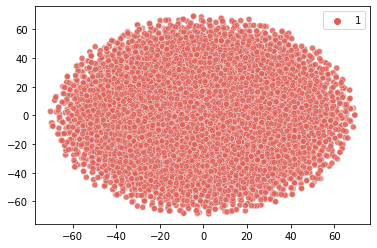

/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 864 samples in 0.000s...
[t-SNE] Computed neighbors for 864 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 864 / 864
[t-SNE] Mean sigma: 1.785090
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.421028
[t-SNE] KL divergence after 1000 iterations: 2.227226
t-SNE done! Time elapsed: 3.546997308731079 seconds


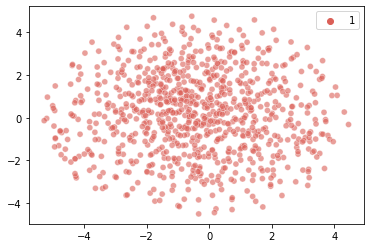

In [22]:
plot_tsne(x_cl)
plot_tsne(x_class)

/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/enoch/g/diplomski/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10864 samples in 0.001s...
[t-SNE] Computed neighbors for 10864 samples in 2.311s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10864
[t-SNE] Computed conditional probabilities for sample 2000 / 10864
[t-SNE] Computed conditional probabilities for sample 3000 / 10864
[t-SNE] Computed conditional probabilities for sample 4000 / 10864
[t-SNE] Computed conditional probabilities for sample 5000 / 10864
[t-SNE] Computed conditional probabilities for sample 6000 / 10864
[t-SNE] Computed conditional probabilities for sample 7000 / 10864
[t-SNE] Computed conditional probabilities for sample 8000 / 10864
[t-SNE] Computed conditional probabilities for sample 9000 / 10864
[t-SNE] Computed conditional probabilities for sample 10000 / 10864
[t-SNE] Computed conditional probabilities for sample 10864 / 10864
[t-SNE] Mean sigma: 1.125423
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.765228
[t-SNE] KL

/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


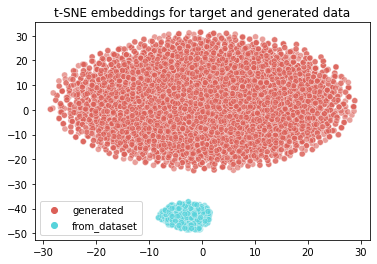

Explained variation per principal component: [0.04900285 0.00231031]


/home/enoch/g/diplomski/env/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


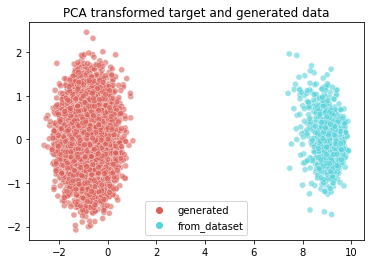

In [23]:
def plot_tsne_joint(data, labels, n_components=2, verbose=1, perplexity=40, n_iter=1000, legend="full", seed=None, use_pca=False):
    if use_pca:
        pca = PCA(n_components*30, random_state=seed)
        data = pca.fit_transform(data)
    
    time_start = time.time()
    tsne = TSNE(n_components=n_components, verbose=verbose, perplexity=perplexity, n_iter=n_iter, random_state=seed)
    tsne_res = tsne.fit_transform(data)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    #plt.figure(figsize=(16,10))
    ax = sns.scatterplot(
        x=tsne_res[:,0], y=tsne_res[:,1],
        hue=labels,
        palette=sns.color_palette("hls", 2),
        data=tsne_res,
        legend=legend,
        alpha=0.6
    )
    ax.set_title("t-SNE embeddings for target and generated data")
    plt.show()

def plot_pca_joint(data, labels, n_components=2, legend="full", seed=None):
    pca = PCA(n_components, random_state=seed)
    pca_res = pca.fit_transform(data)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))    

    plt.figure()
    ax = sns.scatterplot(
        x=pca_res[:,0], y=pca_res[:,1],
        hue=labels,
        palette=sns.color_palette("hls", 2),
        data=pca_res,
        legend="full",
        alpha=0.6
    )
    ax.set_title("PCA transformed target and generated data")
    plt.show()

indices = np.where(np.argmax(y_all, axis=1) == target_class)
y_class = y_all[indices]
labels = np.concatenate((y_cl, y_class), axis=0) 
labels = len(y_cl) * ["generated"] + len(y_class) * ["from_dataset"]
data = np.concatenate((x_cl, x_class), axis=0)

plot_tsne_joint(data, labels, seed=1337, use_pca=True)
plot_pca_joint(data, labels, seed=1337)